# CPDonkey December Notebook
Notebook detailing the formation of a donkeycar pilot using a Deep CNN and a single input image

In [1]:
##Data Profile

#Image Data Example

#Labels

In [1]:
#IMPORTS
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

The data that is fed into the donkeycar's pilot is a single input image. The donkeycar must be able to determine from this image whether to turn left or right. 

This image is a photo taken by the Donkeycar's front-facing camera with a resolution of 120x160. Each image, when taken, is labeled with a user angle (between -1 and 1) and a user throttle (between -1 and 1) - these labels are generated by the donkey program.

Below is an example of a photo taken by the donkey camera. This image has a corresponding json record file listing the angle, throttle, and the milliseconds elapsed since the data recording has started.

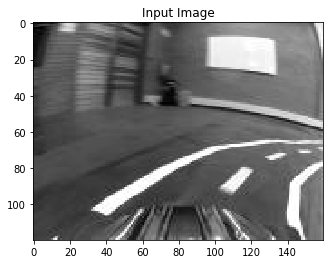

In [3]:
#Data Example
inImg = cv2.imread("101_cam-image_array_.jpg",0)
plt.title('Input Image')
plt.imshow(inImg, cmap = 'gray')

In [1]:
##What must be determined to achieve 'portability'?

#Lane Detection

#Background/Foreground Separation

The above image is fed into the neural network as-is. There is no help provided to the network in finding features such as lane lines etc. This means that the model is very constrained to the environment that it was trained in.

This problem can be solved by training it using many pictures from many different records collected over time and from other donkeycars - but this is time consuming and does not guarantee portability. A better method of making this model more 'portable' would be to incorporate a form of lane detection.

Lane detection can be accomplished by:
*Edge Detection
*Thresholding Images
*U-Net for Image Masking

Text(0.5, 0.98, 'Image Comparison: Canny Edge Detection')

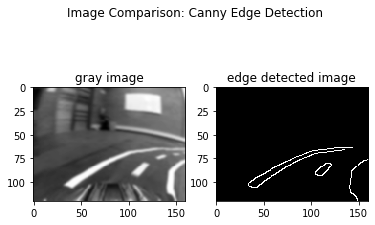

In [7]:
##Edge Detection

#Let's begin with edge detection. This is already built into some of the available parts for the donkey and makes use of 
#canny edge detection. We will show an example using the built-in opencv tools

imageIn = cv2.imread("101_cam-image_array_.jpg",0)
imageIn = cv2.GaussianBlur(imageIn, (5,5), 0)  #Gaussian Blur with a 5x5 kernel
edges = cv2.Canny(imageIn, 500, 200)    #Canny edge detection algorithm with threshold1 set that the strongest edges are found first

plt.subplot(121)
plt.title('gray image')
plt.imshow(imageIn, cmap = 'gray')
plt.subplot(122)
plt.title('edge detected image')
plt.imshow(edges, cmap = 'gray')
plt.suptitle('Image Comparison: Canny Edge Detection')

now: 1579197529022
Post Imread: 1579197529040
Post Numpy Threshold:1579197529044
Post CV Threshold:1579197529050


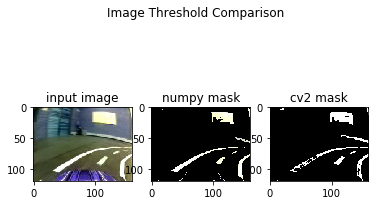

In [5]:
import time

## Thresholding

#Another method of lane detection/isolation could be image thresholding based on colour. A mask is applied to the image based
#on the colour that is to be detected - for example all colours within a certain family of white would most likely count as a
#lane line.

print('now: %d' % int(round(time.time() * 1000)))

imageIn = cv2.imread("101_cam-image_array_.jpg")

print('Post Imread: %d' % int(round(time.time() * 1000)))
#Threshold using numpy:
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold_white = [red_threshold, green_threshold, blue_threshold]

colorMaskWhite = (imageIn[:,:,0] < rgb_threshold_white[0]) | \
                    (imageIn[:,:,1] < rgb_threshold_white[1]) | \
                    (imageIn[:,:,2] < rgb_threshold_white[2])

localImage = np.copy(imageIn)
localImage[colorMaskWhite ] = [0,0,0] 

print('Post Numpy Threshold:%d' % int(round(time.time() * 1000)))
#Threshold using OpenCV:
roiHSV = cv2.cvtColor(imageIn, cv2.COLOR_BGR2HSV) #Convert image from bgr to hsv - using hue and saturation to apply mask

#Threshold for white side lane lines
lowerLIMIT = np.array([20,0,200],np.uint8)
upperLIMIT = np.array([100,60,255],np.uint8)

colLow = lowerLIMIT
colHigh = upperLIMIT

thresh = cv2.inRange(roiHSV, colLow, colHigh)

print('Post CV Threshold:%d' % int(round(time.time() * 1000)))

#plotting
plt.suptitle('Image Threshold Comparison')
plt.subplot(131)
plt.title('input image')
plt.imshow(imageIn, cmap = 'gray')
plt.subplot(132)
plt.title('numpy mask')
plt.imshow(localImage, cmap = 'gray')
plt.subplot(133)
plt.title('cv2 mask')
plt.imshow(thresh, cmap = 'gray')

# U-Net:

The U-Net is a possibility to generate lane lines without being constrained to lighting changes - however, it is a bit of an
'overkill solution' to what is essentially a feature engineering problem. Here is an adapted U-Net pulled from Kaggle's data science bowl


## Setting Up Labels

The labels for training the net, or image masks, have been generated using our numpy mask method from earlier.

495
(120, 160)


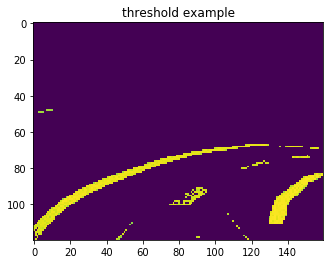

In [2]:
# Label Setup Code:

import os
import natsort

path = 'U_Net_Prototyping/U_Data/U_Train/images/'

done_path = 'U_Net_Prototyping/U_Data/U_Train/masks/'

lst = os.listdir(path)
imlist = []

natsort.natsorted(lst,reverse=False)
i = 1

for file in os.listdir(path):
    imlist.append(file)

#print(imlist)
imlist.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

for file in imlist:
   os.rename(os.path.join(path, file), os.path.join(path, str(i)+'_cam-image_array_'+ '.jpg'))
   i = i+1
imlist = []
for file in os.listdir(path):
    imlist.append(file)

imlist.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#print(imlist)
#print(i)

    
red_threshold = 200
green_threshold = 200
blue_threshold = 200
rgb_threshold_white = [red_threshold, green_threshold, blue_threshold]

i = 1
for file in imlist:
    image = cv2.imread(path + str(i) + '_cam-image_array_.jpg', 1)
    colorMaskWhite = (image[:,:,0] < rgb_threshold_white[0]) | \
                    (image[:,:,1] < rgb_threshold_white[1]) | \
                    (image[:,:,2] < rgb_threshold_white[2])
    localImage = np.copy(image)
    localImage[colorMaskWhite] = [0,0,0]
    (height, width) = localImage.shape[:2]
    point = round(height/3) #create an roi to eliminate unwanted details
    localImage[:point, :width, :] = [0,0,0]
    localImage = cv2.cvtColor(localImage, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(done_path + str(i) +'_mask_.jpg', localImage)
    i = i+1

plt.title('threshold example')
plt.imshow(localImage)
print(i)
print(localImage.shape)

## Training and Validation Data setup

The training and validation data used for this particular U-Net was collected in a lecture hall in preparation for the 2019 
DonkeyCar Presentation, thus this dataset is not representative of all possible locations that the donkeycar will find itself in
meaning that this example will be an overfit model. However, for the purposes of illustrating the use of a U-Net, this will suffice


In [3]:
# Imports - Always run first!
import os
import sys
import random
import warnings
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
%matplotlib inline

Getting and resizing train images and masks ... 


 10%|█████████▎                                                                                  | 13/128 [00:00<00:00, 126.15it/s]

getting and resizing test images:


100%|███████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 123.52it/s]


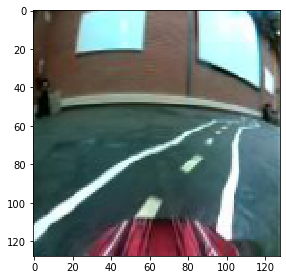

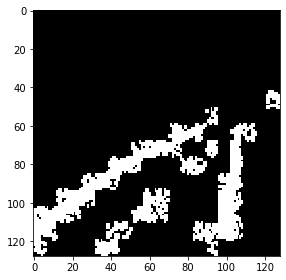

In [4]:
# Data setup:

#Data management:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'U_Net_Prototyping/U_Data/U_Train/'
TEST_PATH = 'U_Net_Prototyping/U_Data/U_Test/'

# Get and order train and test filenames
imgs = []
masks = []
test = []

impath = TRAIN_PATH + 'images/'
maskpath = TRAIN_PATH + 'masks/'

for file in os.listdir(impath):
    imgs.append(file)

for file in os.listdir(maskpath):
    masks.append(file)

for file in os.listdir(TEST_PATH):
    test.append(file)

imgs.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
masks.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

X_train = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8) #create training and testing data tensors
Y_train = np.zeros((len(masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((len(test), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8) #create training and testing data tensors
 
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

i = 1
#Loop through image files and extract data files into numpy arrays
for n, filename in tqdm(enumerate(imgs), total=len(imgs)):
    path = TRAIN_PATH
    img = imread(path + '/images/' + filename)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask_ = imread(path + '/masks/' + str(i) + '_mask_.jpg')
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis = 2)
    mask = mask_ > 200
    Y_train[n] = mask_
    i = i+1

print('getting and resizing test images:')
#get test data:
for n, filename in tqdm(enumerate(test), total=len(test)):
    path = TEST_PATH
    img = imread(path + filename)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

#Just to check if the images are, like, split correctly
ix = np.random.randint(0,len(test))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Network Setup

This network setup is adapted from a model seen on Kaggle. It mostly uses precisely the same structure and layer composition
since this was already a working model. However, some small changes were made - such as the number of dimensions in the convol-
ution layers


In [5]:
#Training and Validation

#imports:

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

#Network Metric - Intersection over Union or Jaccard Index:

def sparse_Mean_IOU(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    pred_pixels = K.argmax(y_pred, axis=-1)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(y_true[:,:,0], i)
        pred_labels = K.equal(pred_pixels, i)
        inter = tf.dtypes.cast(true_labels & pred_labels, tf.int32)
        union = tf.dtypes.cast(true_labels | pred_labels, tf.int32)
        legal_batches = K.sum(tf.dtypes.cast(true_labels, tf.int32), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(tf.gather(ious, indices=tf.where(legal_batches)))) # returns average IoU of the same objects
    iou = tf.stack(iou)
    #legal_labels = ~tf.debugging.is_nan(iou)
    #legal_labels = tf.debugging.assert_none_equal(iou, 'nan')
    #iou = tf.gather(iou, indices=tf.where(legal_labels))
    return K.mean(iou)
#Network Construction:
                  
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [6]:
#Fit model to data:

earlystopper = EarlyStopping(patience=5, verbose=1)  #Patience can be varied to change early stopping behaviour
checkpointer = ModelCheckpoint('UNetSeg.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 444 samples, validate on 50 samples
Epoch 1/50
444/444 [==============================] - 57s 129ms/step - loss: 0.7963 - accuracy: 0.7995 - val_loss: 0.4928 - val_accuracy: 0.8633

Epoch 00001: val_loss improved from inf to 0.49275, saving model to UNetSeg.h5
Epoch 2/50
444/444 [==============================] - 53s 119ms/step - loss: 2.3832 - accuracy: 0.7721 - val_loss: 0.5362 - val_accuracy: 0.8358

Epoch 00002: val_loss did not improve from 0.49275
Epoch 3/50
444/444 [==============================] - 52s 118ms/step - loss: 0.4735 - accuracy: 0.8492 - val_loss: 0.3341 - val_accuracy: 0.8666

Epoch 00003: val_loss improved from 0.49275 to 0.33411, saving model to UNetSeg.h5
Epoch 4/50
444/444 [==============================] - 53s 120ms/step - loss: 1.4469 - accuracy: 0.8613 - val_loss: 47.4741 - val_accuracy: 0.7067

Epoch 00004: val_loss did not improve from 0.33411
Epoch 5/50
444/444 [==============================] - 55s 123ms/step - loss: 2023605.1679 - accuracy: 0.79

C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\lib\site-packages\keras\callbacks\callbacks.py:820: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Chara Grant\Anaconda3\envs\CPDonkey\lib\site-packages\keras\callbacks\callbacks.py:709: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


In [ ]:
# predict from model with random images

ix = np.random.randint(0, len(test))

model = load_model('UNetSeg.h5')


pred_im = model.predict(X_test, verbose=1)

plt.subplot(121)
imshow(X_test[ix])
plt.show()
plt.subplot(122)
imshow(pred_im[ix])
plt.show()

# This Model IS NOT  LEARNING ^

In [13]:
##Main Decision Network

#New Data Labeling and Organisation

#Network Design - Direct Model from Donkeycar

#Donkeycar Design Dashboard with intermediate features -single validation example

#Network Design - Own Design 1 

#Own Design 1 Dashboard with intermediate features - single validation example

#Own Design #n etc.


In [14]:
#Final Design Choices


In [15]:
#Compiled Full Pilot System - I.P.O and dashboard with selectable input images 